# Single Scenario Run Test Notebook

This notebook is designed to:
1. Select a specific scenario from `config.py`.
2. Perform a single Monte Carlo simulation for that scenario.
3. Fit the proposed Bayesian model using NumPyro (from your `sampler.py`).
4. Calculate benchmark CFR estimates (cCFR, aCFR).
5. Generate and display a time-series plot comparing true CFRs, 
   proposed model estimates (with 95% CrI and counterfactual), and benchmark estimates.

**Prerequisites:**
- All helper Python modules (`config.py`, `data_generation.py`, `benchmarks.py`, 
  `model_fitting.py`, `sampler.py`, `evaluation.py`, `results_io.py`, `plotting.py`) 
  must be in the same directory as this notebook or accessible in your `PYTHONPATH`.
- **`sampler.py` MUST be modified to accept `rng_key` as an argument in its `sample` function 
  for proper MCMC seeding.** #   (Example: def sample(..., rng_key=None): ... mcmc.run(rng_key, **data))

In [96]:
import pandas as pd
import numpy as np
import os
import time
import jax
from tqdm.auto import tqdm
import importlib
import matplotlib.pyplot as plt

# Import and force-reload all custom modules
import config; importlib.reload(config)
import data_generation; importlib.reload(data_generation)
import benchmarks; importlib.reload(benchmarks)
import evaluation; importlib.reload(evaluation)
import plotting; importlib.reload(plotting)
import tables; importlib.reload(tables)
import results_io; importlib.reload(results_io)
import model_fitting; importlib.reload(model_fitting)
import sampler; importlib.reload(sampler)

<module 'sampler' from 'C:\\Users\\user\\Desktop\\BICE-CFR\\BICE-CFR\\sampler.py'>

In [97]:
# --- 1. Select Scenario and Generate Data ---

print("\n--- Single Monte Carlo Run Test ---")

scenario_to_test_id = "S09" # A challenging scenario with K=1 intervention
test_seed = 42

try:
    scenario_config = next(s for s in config.SCENARIOS if s['id'] == scenario_to_test_id)
except StopIteration:
    print(f"Error: Scenario '{scenario_to_test_id}' not found in config.py")
    
print(f"Generating data for scenario: {scenario_config['id']}...")
sim_data = data_generation.simulate_scenario_data(scenario_config, run_seed=test_seed)
print("Data generated successfully.")


--- Single Monte Carlo Run Test ---
Generating data for scenario: S09...
Data generated successfully.


In [98]:
jax_prng_key = jax.random.PRNGKey(test_seed)

print("\nFitting sCFR model...")
posterior_scfr, _ = model_fitting.fit_proposed_model(sim_data, jax_prng_key, use_orthogonalization=False)

print("Fitting sCFR-O model...")
jax_prng_key, subkey = jax.random.split(jax_prng_key)
posterior_scfr_o, _ = model_fitting.fit_proposed_model(sim_data, subkey, use_orthogonalization=True)

print("Fitting aCFR and cCFR...")
benchmarks_r_t = {
        "cCFR_cumulative": benchmarks.calculate_crude_cfr(sim_data["d_t"], sim_data["c_t"], cumulative=True),
        "aCFR_cumulative": benchmarks.calculate_nishiura_cfr_cumulative(sim_data["d_t"], sim_data["c_t"], sim_data["f_s_true"])
    }
benchmark_cis = benchmarks.calculate_benchmark_cis_with_bayesian(sim_data["d_t"], sim_data["c_t"], sim_data["f_s_true"])

print("Fitting ITS benchmark model...")
its_results = benchmarks.calculate_its_with_penalized_mle(
    d_t=sim_data["d_t"], c_t=sim_data["c_t"], f_s=sim_data["f_s_true"],
    Bm=sim_data["Bm_true"],
    intervention_times_abs=sim_data["true_intervention_times_0_abs"],
    intervention_signs=sim_data["beta_signs_true"]
)

print("All models fitted successfully.")


Fitting sCFR model...
Fitting sCFR-O model...
    -> Applying orthogonalization to sCFR model predictors.
Fitting aCFR and cCFR...
Fitting ITS benchmark model...
All models fitted successfully.


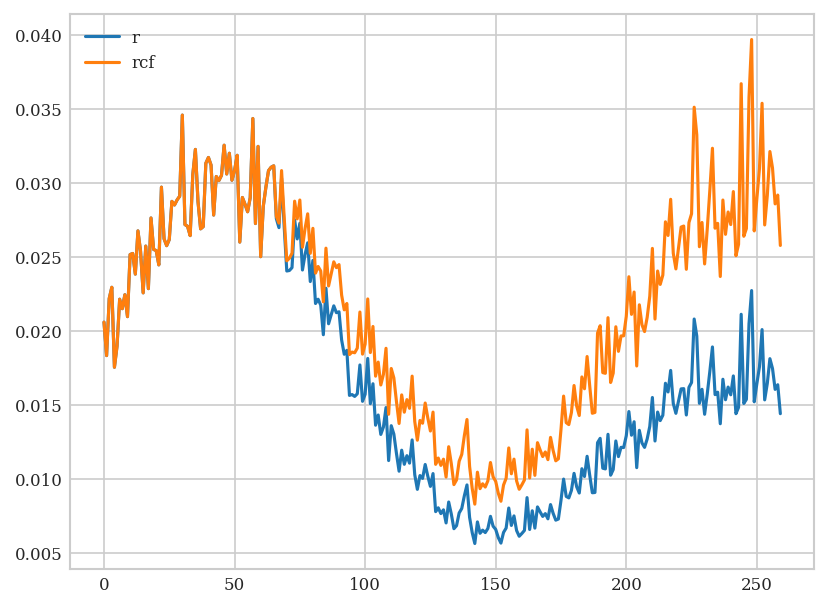

In [99]:
plt.plot(sim_data['true_r_0_t'],label="r")
plt.plot(sim_data['true_rcf_0_t'],label="rcf")
plt.legend()

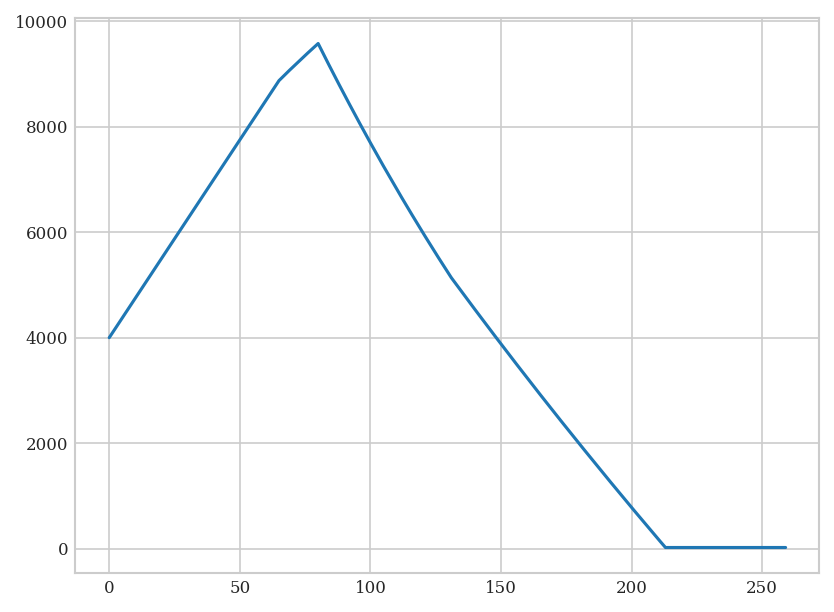

In [100]:
plt.plot(sim_data['c_t'])

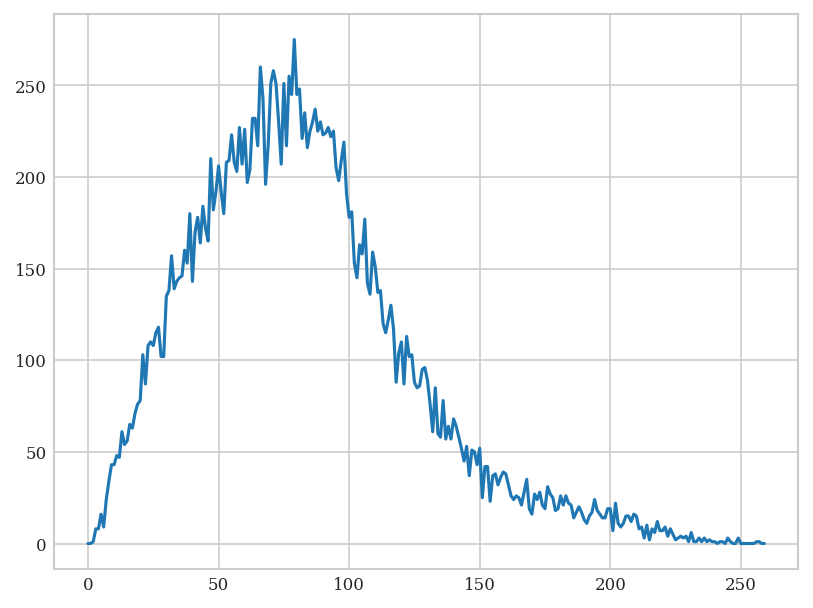

In [101]:
plt.plot(sim_data['d_t'])

In [102]:
# Collect all metrics
all_metrics = evaluation.collect_all_metrics(
    sim_data, posterior_scfr, posterior_scfr_o, 
    benchmarks_r_t, benchmark_cis, its_results
)

# Print the calculated metrics in a readable format
T_analyze = config.T_ANALYSIS_LENGTH
true_r_t_analysis = sim_data["true_r_0_t"][:T_analyze]
true_rcf_0_t_analysis = sim_data["true_rcf_0_t"][:T_analyze]

In [103]:
print("\n--- Curve Fit Metrics ---")
for model_name, suffix in [("sCFR-O", "_sCFR_O"), ("ITS", "_its")]:
    print(f"--- {model_name} ---")
    print(f"  Factual MAE:      {all_metrics.get(f'mae_rt{suffix}', np.nan):.4f}")
    print(f"  Factual MCIW:     {all_metrics.get(f'mciw_rt{suffix}', np.nan):.4f}")
    print(f"  Factual MCIC:     {all_metrics.get(f'mcic_rt{suffix}', np.nan):.4f}")
    print(f"  Counterfactual MAE: {all_metrics.get(f'mae_rcf{suffix}', np.nan):.4f}")
    print(f"  Counterfactual MCIW:{all_metrics.get(f'mciw_rcf{suffix}', np.nan):.4f}")
    print(f"  Counterfactual MCIC:{all_metrics.get(f'mcic_rcf{suffix}', np.nan):.4f}")

print("\n--- Parameter Estimation Metrics ---")
num_interventions = sim_data["num_interventions_true_K"]
if num_interventions > 0:
    true_gammas = np.log(sim_data["true_beta_abs_0"] + 1e-9)
    true_lambdas = sim_data["true_lambda_0"]
    for k in range(num_interventions):
        for model_name, suffix in [("sCFR-O", "_sCFR_O"), ("ITS", "_its")]:
            print(f"--- {model_name} (Intervention {k+1}) ---")
            print(f"  Gamma Bias:     {all_metrics.get(f'bias_gamma_{k+1}{suffix}', np.nan):.4f}")
            print(f"  Gamma Width:    {all_metrics.get(f'width_gamma_{k+1}{suffix}', np.nan):.4f}")
            print(f"  Gamma Coverage: {all_metrics.get(f'cover_gamma_{k+1}{suffix}', 'N/A')}")
            print(f"  Lambda Bias:    {all_metrics.get(f'bias_lambda_{k+1}{suffix}', np.nan):.4f}")
            print(f"  Lambda Width:   {all_metrics.get(f'width_lambda_{k+1}{suffix}', np.nan):.4f}")
            print(f"  Lambda Coverage:{all_metrics.get(f'cover_lambda_{k+1}{suffix}', 'N/A')}")



--- Curve Fit Metrics ---
--- sCFR-O ---
  Factual MAE:      0.0012
  Factual MCIW:     0.0085
  Factual MCIC:     0.9700
  Counterfactual MAE: 0.0032
  Counterfactual MCIW:0.0346
  Counterfactual MCIC:1.0000
--- ITS ---
  Factual MAE:      0.0018
  Factual MCIW:     0.0014
  Factual MCIC:     0.2700
  Counterfactual MAE: 0.0041
  Counterfactual MCIW:0.0030
  Counterfactual MCIC:0.2100

--- Parameter Estimation Metrics ---
--- sCFR-O (Intervention 1) ---
  Gamma Bias:     -1.6132
  Gamma Width:    3.6651
  Gamma Coverage: True
  Lambda Bias:    0.6989
  Lambda Width:   3.4103
  Lambda Coverage:True
--- ITS (Intervention 1) ---
  Gamma Bias:     -2.1705
  Gamma Width:    0.1364
  Gamma Coverage: False
  Lambda Bias:    1.6756
  Lambda Width:   0.0097
  Lambda Coverage:False
--- sCFR-O (Intervention 2) ---
  Gamma Bias:     -1.2753
  Gamma Width:    3.4183
  Gamma Coverage: True
  Lambda Bias:    0.5316
  Lambda Width:   3.2201
  Lambda Coverage:True
--- ITS (Intervention 2) ---
  Gamma


Generating final comparison plot...

Comparison plot saved to: ./simulation_outputs/plots/test_single_run_scen_S09.pdf


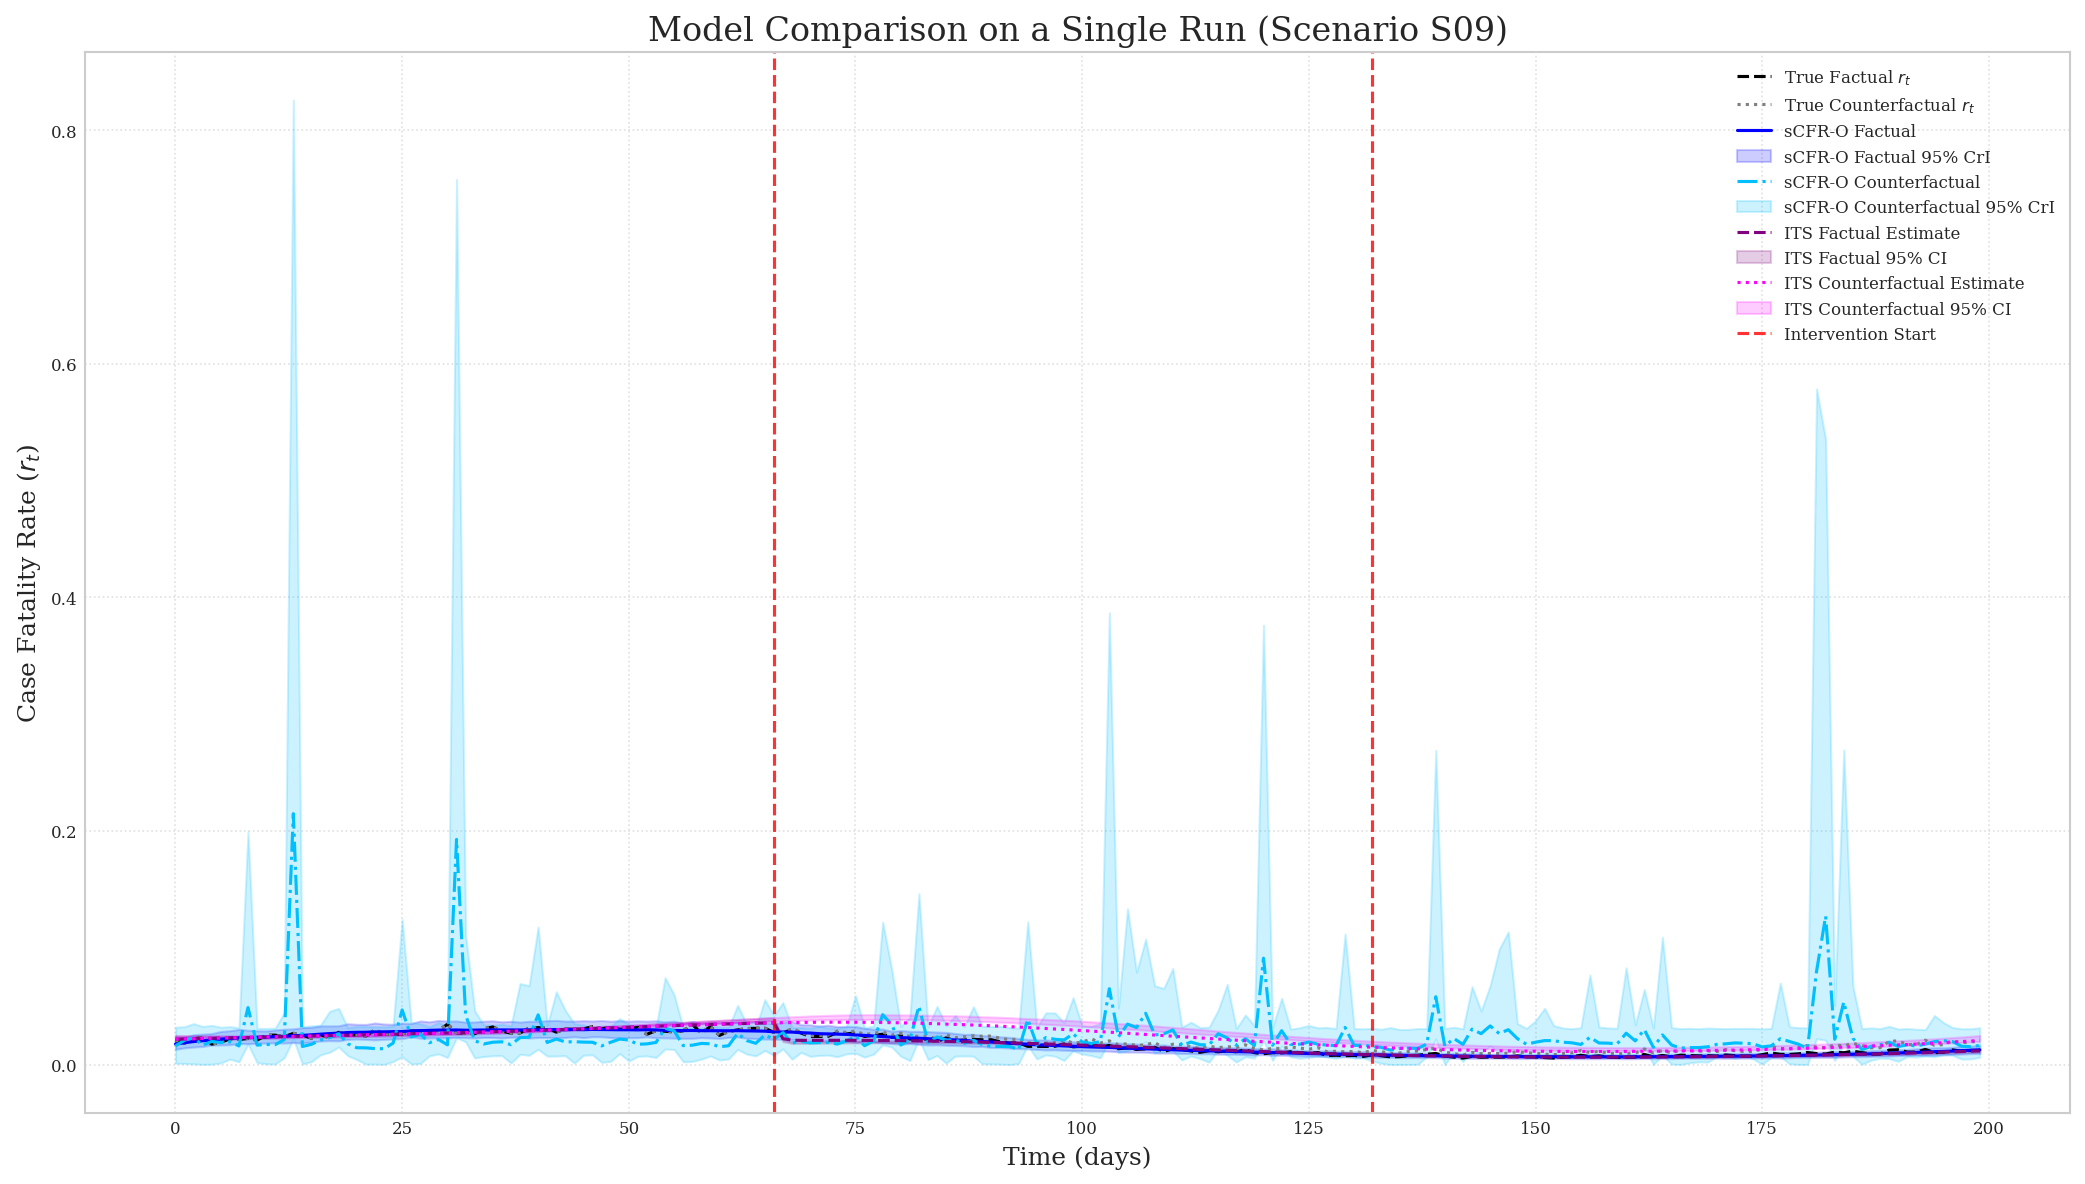

In [104]:
from scipy.special import logit, expit as sigmoid

print("\nGenerating final comparison plot...")
time_points = np.arange(T_analyze)

fig, ax = plt.subplots(figsize=(14, 8))

# Plot ground truth
ax.plot(time_points, true_r_t_analysis, color='black', linestyle='--', label="True Factual $r_t$")
ax.plot(time_points, true_rcf_0_t_analysis, color='gray', linestyle=':', label="True Counterfactual $r_t$")

# Plot sCFR-O (the superior Bayesian model)
scfr_o_p_mean, scfr_o_p_lower, scfr_o_p_upper = evaluation.get_posterior_estimates(posterior_scfr_o, "p")
ax.plot(time_points, scfr_o_p_mean[:T_analyze], color='blue', label="sCFR-O Factual")
ax.fill_between(time_points, scfr_o_p_lower[:T_analyze], scfr_o_p_upper[:T_analyze], 
                color='blue', alpha=0.2, label="sCFR-O Factual 95% CrI")

# Get sCFR-O counterfactual after transformation
posterior_scfr_o = evaluation.transform_alpha_post_hoc(posterior_scfr_o, sim_data)
M_tf = sim_data["Bm_true"] @ posterior_scfr_o['alpha_transformed'].T
eps = posterior_scfr_o.get('eps', np.zeros_like(M_tf.T)).T
p_cf_o = sigmoid(M_tf + eps)
rcf_mean_o, rcf_lower_o, rcf_upper_o = np.mean(p_cf_o, axis=0), np.percentile(p_cf_o, 2.5, axis=0), np.percentile(p_cf_o, 97.5, axis=0)

# rcf_mean_o, rcf_lower_o, rcf_upper_o = evaluation.get_posterior_estimates(posterior_scfr_o, "p_cf")
ax.plot(time_points, rcf_mean_o[:T_analyze], color='deepskyblue', linestyle='-.', label="sCFR-O Counterfactual")
ax.fill_between(time_points, rcf_lower_o[:T_analyze], rcf_upper_o[:T_analyze], 
                color='deepskyblue', alpha=0.2, label="sCFR-O Counterfactual 95% CrI")

# Plot ITS benchmark
ax.plot(time_points, its_results["its_factual_mean"][:T_analyze], color='purple', linestyle='--', label="ITS Factual Estimate")
ax.fill_between(time_points, its_results["its_factual_lower"][:T_analyze], its_results["its_factual_upper"][:T_analyze], 
                color='purple', alpha=0.2, label="ITS Factual 95% CI")

ax.plot(time_points, its_results["its_counterfactual_mean"][:T_analyze], color='magenta', linestyle=':', label="ITS Counterfactual Estimate")
ax.fill_between(time_points, its_results["its_counterfactual_lower"][:T_analyze], its_results["its_counterfactual_upper"][:T_analyze], 
                color='magenta', alpha=0.2, label="ITS Counterfactual 95% CI")


intervention_times = sim_data["true_intervention_times_0_abs"]
for i, t_int in enumerate(intervention_times):
    if t_int < T_analyze:
        ax.axvline(x=t_int, color='red', linestyle='--', alpha=0.8, 
                   label=f"Intervention Start" if i == 0 else "")

# Final plot formatting
ax.set_title(f"Model Comparison on a Single Run (Scenario {scenario_to_test_id})", fontsize=16)
ax.set_xlabel("Time (days)", fontsize=12)
ax.set_ylabel("Case Fatality Rate ($r_t$)", fontsize=12)
ax.legend(loc='best')
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

output_dir = config.OUTPUT_DIR_PLOTS
os.makedirs(output_dir, exist_ok=True)
plot_filename = os.path.join(output_dir, f"test_single_run_scen_{scenario_to_test_id}.pdf")
plt.savefig(plot_filename)
print(f"\nComparison plot saved to: {plot_filename}")

plt.show()

In [105]:
posterior_scfr_o['alpha'].mean(axis=0)

Array([-3.9844007, -3.5730085, -3.4443939, -3.5070767, -4.425261 ,
       -5.103753 , -4.9413548, -3.468315 , -5.0036907, -5.3087454],      dtype=float32)

In [83]:
# evaluation.get_posterior_estimates(posterior_scfr_o, "beta_abs")

# if 'beta_abs' in posterior_samples and posterior_samples['beta_abs'].shape[1] > 0:
#     plt.figure(figsize=(6,3))
#     plt.hist(posterior_samples['beta_abs'][:,0], bins=30, density=True, alpha=0.7)
#     plt.title(f"Posterior for beta_abs_1 (Scenario {selected_scenario_config['id']})")
#     plt.show()

In [84]:
# if 'lambda' in posterior_samples and posterior_samples['lambda'].shape[1] > 0:
#     plt.figure(figsize=(6,3))
#     plt.hist(posterior_samples['lambda'][:,0], bins=30, density=True, alpha=0.7)
#     plt.title(f"Posterior for lambda_1 (Scenario {selected_scenario_config['id']})")
#     plt.show()